#Rafael Souza de Barros
## Objetivo e perguntas do projeto MVP - Engenharia de dados
### Pós-graduação em ciência de dados e _analytics_ - PUC-RIO


O presente projeto foi elaborado para fins de conclusão de módulo (_sprint_) de engenhraria de dados do curso de pós-graduação em ciência de dados e _analytics_ da PUC-RIO e tem como objetivo consumir dados disponibilizados de forma pública e aberta pelo Supremo Tribunal Federal - STF, por meio do site "Corte Aberta", disponível em (https://portal.stf.jus.br/hotsites/corteaberta/).

O objetivo é criar um banco de dados que sirva para analisar a tramitação dos processos no STF, suas principais características e resultados, o que pode auxiliar diversas instituições públicas e privadas na gestão de demandas, especialmente as repetitivas, explicitando os custos e a eficiência da judicialização massificada dos mais diversos temas.

Decidi utilizar nesse projeto os conjuntos de dados sobre distribuições e registros e sobre decisões (monocráticas ou colegiadas), filtrados para o ano de 2025, por uma questão de praticidade e limitação do volume de dados. 

Com esses dados, objetiva-se identificar possíveis tendências de julgamentos da Suprema Corte em função dos temas, do Tribunal de origem e das partes, respondendo as seguintes perguntas:

1. Quais e quantos processos foram autuados no ano de 2025?
2. É possível identificar as pessoas e entidades com maior quantidade de recursos e o polo processual que elas ocupam?
3. Qual o resultado dos julgamentos desses processos? 
4. Existe alguma tendência nos julgamentos (favoráveis ou desfavoráveis) por tema, origem ou pessoa/entidade?
5. Qual tempo médio de tramitação dos processos em geral e por Ministro Relator?

Para alcançar a resposta dessas perguntas serão seguidas as seguintes etapas:

1. Carregar no _Databricks_ as tabelas obtidas no site (https://portal.stf.jus.br/hotsites/corteaberta/)
2. Manipular/limpar os dados (definir tipos de dados nas tabelas, juntar colunas Classe e Nº Processo, fazer join das 2 tabelas, etc.)
3. Construir catálogo de dados das tabelas ingeridas e limpas
4. Avaliar a qualidade dos dados e definir se há problemas que impeçam a resposta das perguntas iniciais
5. Analisar os dados e responder as perguntas propostas
6. Auto avaliação 




#### 1. Carregamento no _Databricks_ das tabelas obtidas no site (https://portal.stf.jus.br/hotsites/corteaberta/) - camada Bronze

**Os dados foram carregados do meu computador após download, em razão de dificuldades na obtenção dos dados de forma automatizada, visto que os dados estão disponibilizados no _link_ acima, mas são gerados por um Qlik, cujo _link_ não fica visível no html ou Devtools.** 

In [0]:

# Carregando as funções

from pyspark.sql.functions import col, to_date, when, trim, regexp_replace, coalesce, lit, concat_ws, sum, count
from pyspark.sql.types import StringType
from pyspark.sql import DataFrame


# 1. Ler a tabelas carregadas no catálogo

dist_raw = spark.table("distribuicoes_2025_stf")

dec_raw = spark.table("decisoes_2025_stf")

 


In [0]:
dist_raw.printSchema()

root
 |-- Tipo de andamento: string (nullable = true)
 |-- Classe: string (nullable = true)
 |-- Nº do processo: long (nullable = true)
 |-- Link: string (nullable = true)
 |-- Ministro(a): string (nullable = true)
 |-- Última localização: string (nullable = true)
 |-- Data da autuação: date (nullable = true)
 |-- Data da baixa: string (nullable = true)
 |-- Em tramitação: string (nullable = true)
 |-- Grupo origem: string (nullable = true)
 |-- Meio processo: string (nullable = true)
 |-- Data do andamento: date (nullable = true)
 |-- Andamento: string (nullable = true)
 |-- Subgrupo do andamento: string (nullable = true)
 |-- Indicador de substituição ou redistribuição: string (nullable = true)
 |-- Orgão origem: string (nullable = true)
 |-- Procedência: string (nullable = true)
 |-- Ramo do direito: string (nullable = true)
 |-- Assunto completo: string (nullable = true)
 |-- Polo ativo: string (nullable = true)
 |-- Advogado polo ativo: string (nullable = true)
 |-- Polo passivo: 

In [0]:
dec_raw.printSchema()

root
 |-- idFatoDecisao: long (nullable = true)
 |-- Processo: string (nullable = true)
 |-- Relator atual: string (nullable = true)
 |-- Meio Processo: string (nullable = true)
 |-- Origem decisão: string (nullable = true)
 |-- Ambiente julgamento: string (nullable = true)
 |-- Data de autuação: string (nullable = true)
 |-- Data baixa: string (nullable = true)
 |-- Indicador colegiado: string (nullable = true)
 |-- Ano da decisão: long (nullable = true)
 |-- Data da decisão: string (nullable = true)
 |-- Tipo decisão: string (nullable = true)
 |-- Andamento decisão: string (nullable = true)
 |-- Observação do andamento: string (nullable = true)
 |-- Ramo direito: string (nullable = true)
 |-- Assuntos do processo: string (nullable = true)
 |-- Indicador de tramitação: string (nullable = true)
 |-- Órgão julgador: string (nullable = true)



#### 2. Manipular/limpar os dados (definir tipos de dados nas tabelas, juntar colunas Classe e Nº Processo, fazer join das 2 tabelas, etc.) - camada Prata

##### 2.1 Ajustando tipos de dados das colunas

Identificou-se pelas tabelas acima, que os dados ingeridos não tiveram os tipos de dados corretamente classificados, como as colunas "Data de Autuação" e "Data Baixa" que foram consideradas como _string_.

Assim, foi necessário identificar manualmente esses tipos. Além disso, algumas colunas de datas vieram no formato data/hora e outras apenas no formata data (dd/mm/yyyy), sendo necessária a manipulação para utilização desses dados.

In [0]:


dist_typed = (
    dist_raw
    .withColumn("Nº do processo", col("Nº do processo").cast("long"))
    .withColumn(
        "Data da autuação",
        when(trim(col("Data da autuação")) == "-", None)
        .otherwise(to_date(col("Data da autuação"), "dd/MM/yyyy"))
    )
    .withColumn(
        "Data da baixa",
        when(trim(col("Data da baixa")) == "-", None)
        .otherwise(to_date(col("Data da baixa"), "dd/MM/yyyy"))
    )
    .withColumn(
        "Data do andamento",
        when(trim(col("Data do andamento")) == "-", None)
        .otherwise(to_date(col("Data do andamento"), "dd/MM/yyyy"))
    )
    .withColumn(
        "Em tramitação",
        when(trim(col("Em tramitação")) == "Sim", True)
        .when(trim(col("Em tramitação")) == "Não", False)
        .otherwise(None)
        .cast("boolean")
    )
    .withColumn(
        "Indicador de substituição ou redistribuição",
        when(trim(col("Indicador de substituição ou redistribuição")) == "Sim", True)
        .when(trim(col("Indicador de substituição ou redistribuição")) == "Não", False)
        .otherwise(None)
        .cast("boolean")
    )
    .withColumn(
    "processo",
    concat_ws(" ", col("Classe"), col("Nº do processo"))
)
)



def normaliza_data(c):
    return when(trim(col(c)).isin("*NI*", "-", ""), lit(None)) \
        .otherwise(
            to_date(
                regexp_replace(col(c), r"\s.*", ""),
                "dd/MM/yyyy"
            )
        )

dec_typed = (
    dec_raw
    .withColumn("idFatoDecisao", col("idFatoDecisao").cast("long"))
    .withColumn("Ano da decisão", col("Ano da decisão").cast("int"))
    .withColumn("Data de autuação", normaliza_data("Data de autuação"))
    .withColumn("Data baixa", normaliza_data("Data baixa"))
    .withColumn("Data da decisão", normaliza_data("Data da decisão"))
    .withColumn(
        "Indicador de tramitação",
        when(trim(col("Indicador de tramitação")) == "Sim", True)
        .when(trim(col("Indicador de tramitação")) == "Não", False)
        .otherwise(None)
        .cast("boolean")
    )
)

##### 2.2 Renomeando colunas e salvando em formato Delta na camada _Silver_

Para salvar os conjuntos de dados em formato Delta, foi constatado que os nomes das colunas não eram suportados por esse formato, tendo sido preciso a alteração dos nomes para formas compatíveis.

Também se identiicou que alguns valores inexistentes estavam preenchidos com símbolos, o que dificulta a sua contagem como nulos, tendo sido feita, então, a explicitação desses valores nulos, para fins de avaliação da qualidade dos dados.

Por fim, foi criada a base de dados "silver" e salvos os dados limpos em formato Delta.

In [0]:


# Renomear colunas para nomes válidos em Delta

dec = dec_typed

rename_map_dec = {
    "idFatoDecisao": "id_fato_decisao",
    "Processo": "processo",
    "Relator atual": "relator_atual",
    "Meio Processo": "meio_processo",
    "Origem decisão": "origem_decisao",
    "Ambiente julgamento": "ambiente_julgamento",
    "Data de autuação": "data_autuacao",
    "Data baixa": "data_baixa",
    "Indicador colegiado": "indicador_colegiado",
    "Ano da decisão": "ano_decisao",
    "Data da decisão": "data_decisao",
    "Tipo decisão": "tipo_decisao",
    "Andamento decisão": "andamento_decisao",
    "Observação do andamento": "observacao_andamento",
    "Ramo direito": "ramo_direito",
    "Assuntos do processo": "assuntos_processo",
    "Indicador de tramitação": "indicador_tramitacao",
    "Órgão julgador": "orgao_julgador",
}

for old, new in rename_map_dec.items():
    dec = dec.withColumnRenamed(old, new)



dist = dist_typed

rename_map_dist = {
    "Tipo de andamento": "tipo_andamento",
    "Classe": "classe",
    "Nº do processo": "num_processo",
    "Link": "link",
    "Ministro(a)": "ministro",
    "Última localização": "ultima_localizacao",
    "Data da autuação": "data_autuacao",
    "Data da baixa": "data_baixa",
    "Em tramitação": "em_tramitacao",
    "Grupo origem": "grupo_origem",
    "Meio processo": "meio_processo",
    "Data do andamento": "data_andamento",
    "Andamento": "andamento",
    "Subgrupo do andamento": "subgrupo_andamento",
    "Indicador de substituição ou redistribuição": "ind_substituicao_redistribuicao",
    "Orgão origem": "orgao_origem",
    "Procedência": "procedencia",
    "Ramo do direito": "ramo_direito",
    "Assunto completo": "assunto_completo",
    "Polo ativo": "polo_ativo",
    "Advogado polo ativo": "advogado_polo_ativo",
    "Polo passivo": "polo_passivo",
    "Advogado polo passivo": "advogado_polo_passivo",
    "processo": "processo"
}

for old, new in rename_map_dist.items():
    dist = dist.withColumnRenamed(old, new)


# Explicitando valores nulos para as linhas preenchidas com "-", "", "*NI*", "N/I", "NA"

dist_corrigido = dist

for campo in dist.schema.fields:
    if isinstance(campo.dataType, StringType):
        dist_corrigido = dist_corrigido.withColumn(
            campo.name,
            when(trim(col(campo.name)).isin("-", "", "*NI*", "N/I", "NA"), None)
            .otherwise(col(campo.name))
        )

dec_corrigido = dec

for campo in dec.schema.fields:
    if isinstance(campo.dataType, StringType):
        dec_corrigido = dec_corrigido.withColumn(
            campo.name,
            when(trim(col(campo.name)).isin("-", "", "*NI*", "N/I", "NA"), None)
            .otherwise(col(campo.name))
        )

# Gravando Silver em Delta

spark.sql("CREATE DATABASE IF NOT EXISTS silver")


dec_corrigido.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("silver.decisoes2025stf")


dist_corrigido.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("silver.distribuicoes2025stf")    




In [0]:
dist = spark.table("silver.distribuicoes2025stf")

dist.printSchema()

root
 |-- tipo_andamento: string (nullable = true)
 |-- classe: string (nullable = true)
 |-- num_processo: long (nullable = true)
 |-- link: string (nullable = true)
 |-- ministro: string (nullable = true)
 |-- ultima_localizacao: string (nullable = true)
 |-- data_autuacao: date (nullable = true)
 |-- data_baixa: date (nullable = true)
 |-- em_tramitacao: boolean (nullable = true)
 |-- grupo_origem: string (nullable = true)
 |-- meio_processo: string (nullable = true)
 |-- data_andamento: date (nullable = true)
 |-- andamento: string (nullable = true)
 |-- subgrupo_andamento: string (nullable = true)
 |-- ind_substituicao_redistribuicao: boolean (nullable = true)
 |-- orgao_origem: string (nullable = true)
 |-- procedencia: string (nullable = true)
 |-- ramo_direito: string (nullable = true)
 |-- assunto_completo: string (nullable = true)
 |-- polo_ativo: string (nullable = true)
 |-- advogado_polo_ativo: string (nullable = true)
 |-- polo_passivo: string (nullable = true)
 |-- advog

In [0]:
dec = spark.table("silver.decisoes2025stf")

dec.printSchema()

root
 |-- id_fato_decisao: long (nullable = true)
 |-- processo: string (nullable = true)
 |-- relator_atual: string (nullable = true)
 |-- meio_processo: string (nullable = true)
 |-- origem_decisao: string (nullable = true)
 |-- ambiente_julgamento: string (nullable = true)
 |-- data_autuacao: date (nullable = true)
 |-- data_baixa: date (nullable = true)
 |-- indicador_colegiado: string (nullable = true)
 |-- ano_decisao: integer (nullable = true)
 |-- data_decisao: date (nullable = true)
 |-- tipo_decisao: string (nullable = true)
 |-- andamento_decisao: string (nullable = true)
 |-- observacao_andamento: string (nullable = true)
 |-- ramo_direito: string (nullable = true)
 |-- assuntos_processo: string (nullable = true)
 |-- indicador_tramitacao: boolean (nullable = true)
 |-- orgao_julgador: string (nullable = true)



##### 2.3 Criando novas medidas para resposta das perguntas iniciais e salvando dados na camada _Gold_

Criando visão de quantidade de processos distribuídos e tempo de tramitação até decisões

In [0]:
%sql

/* Cria a base de dados 'gold' */
CREATE DATABASE IF NOT EXISTS gold;


/* Cria visão com análise da quantidade de decisões por processo e o tempo de tramitação, inclusive relacionado a julgamento de recursos interno */
CREATE OR REPLACE VIEW gold.vw_distribuicoes2025_decisoes AS
WITH dec_base AS (
    SELECT
        processo,
        data_decisao,
        tipo_decisao,
        relator_atual
    FROM silver.decisoes2025stf
    WHERE data_decisao IS NOT NULL
),

/* Agregado geral por processo */
dec_agg AS (
    SELECT
        processo,
        MIN(data_decisao) AS primeira_decisao,
        MAX(data_decisao) AS ultima_decisao,
        COUNT(*)          AS qtd_decisoes
    FROM dec_base
    GROUP BY processo
),

/* Dados da PRIMEIRA decisão (tipo_decisao e relator_atual) */
dec_primeira AS (
    SELECT
        b.processo,
        b.data_decisao  AS primeira_decisao,
        b.tipo_decisao  AS tipo_decisao_primeira,
        b.relator_atual AS relator_atual_primeira
    FROM dec_base b
    INNER JOIN dec_agg a
        ON a.processo = b.processo
       AND b.data_decisao = a.primeira_decisao
),

/* 1ª decisão de recurso interno POSTERIOR à primeira decisão */
dec_recurso AS (
    SELECT
        b.processo,
        MIN(b.data_decisao) AS segunda_decisao_recurso
    FROM dec_base b
    INNER JOIN dec_agg a
        ON a.processo = b.processo
    WHERE b.data_decisao > a.primeira_decisao
      AND b.tipo_decisao = 'Decisão em recurso interno'
    GROUP BY b.processo
)

SELECT
    d.*,

    /* decisões (com tipo/relator da primeira decisão) */
    p.primeira_decisao,
    p.tipo_decisao_primeira,
    p.relator_atual_primeira,
    r.segunda_decisao_recurso AS segunda_decisao,
    a.ultima_decisao,
    a.qtd_decisoes,

    CASE WHEN a.processo IS NOT NULL THEN TRUE ELSE FALSE END AS possui_decisao,

    /* 1) Tempo (dias) entre autuação e baixa */
    CASE
        WHEN d.data_baixa IS NULL OR d.data_autuacao IS NULL OR d.data_baixa < d.data_autuacao THEN NULL
        ELSE DATEDIFF(d.data_baixa, d.data_autuacao)
    END AS tempo_tramitacao,

    /* 3) Tempo (dias) entre autuação e 1ª decisão */
    CASE
        WHEN p.primeira_decisao IS NULL OR d.data_autuacao IS NULL THEN NULL
        ELSE DATEDIFF(p.primeira_decisao, d.data_autuacao)
    END AS tempo_analise_relator,

    /* 2) Tempo (dias) entre 1ª decisão e 1ª decisão de recurso interno posterior */
    CASE
        WHEN p.primeira_decisao IS NULL OR r.segunda_decisao_recurso IS NULL THEN NULL
        ELSE DATEDIFF(r.segunda_decisao_recurso, p.primeira_decisao)
    END AS tempo_recurso_interno

FROM silver.distribuicoes2025stf d
LEFT JOIN dec_agg a
    ON d.processo = a.processo
LEFT JOIN dec_primeira p
    ON d.processo = p.processo
LEFT JOIN dec_recurso r
    ON d.processo = r.processo;




/*Olhando as 20 primeira linhas da visão */
SELECT *
FROM gold.vw_distribuicoes2025_decisoes
LIMIT 5 ;




tipo_andamento,classe,num_processo,link,ministro,ultima_localizacao,data_autuacao,data_baixa,em_tramitacao,grupo_origem,meio_processo,data_andamento,andamento,subgrupo_andamento,ind_substituicao_redistribuicao,orgao_origem,procedencia,ramo_direito,assunto_completo,polo_ativo,advogado_polo_ativo,polo_passivo,advogado_polo_passivo,processo,primeira_decisao,tipo_decisao_primeira,relator_atual_primeira,segunda_decisao,ultima_decisao,qtd_decisoes,possui_decisao,tempo_tramitacao,tempo_analise_relator,tempo_recurso_interno
Distribuído aos Ministros,AC,3891,https://portal.stf.jus.br/processos/detalhe.asp?incidente=4792024,MIN. LUÍS ROBERTO BARROSO,GABINETE MINISTRO NUNES MARQUES,2015-06-10,null,true,Originárias,Físico,2025-09-29,"Substituição do Relator, art. 38 do RISTF",Substituição,true,SUPREMO TRIBUNAL FEDERAL,DISTRITO FEDERAL,DIREITO PROCESSUAL PENAL,0 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL,null,null,null,null,AC 3891,null,null,null,null,null,null,false,null,null,null
Distribuído aos Ministros,AC,3997,https://portal.stf.jus.br/processos/detalhe.asp?incidente=4864855,MIN. LUÍS ROBERTO BARROSO,GABINETE MINISTRO NUNES MARQUES,2015-10-08,null,true,Originárias,Físico,2025-09-29,"Substituição do Relator, art. 38 do RISTF",Substituição,true,SUPREMO TRIBUNAL FEDERAL,DISTRITO FEDERAL,DIREITO PROCESSUAL PENAL,0 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL,MPF,null,null,null,AC 3997,null,null,null,null,null,null,false,null,null,null
Distribuído aos Ministros,AC,4008,https://portal.stf.jus.br/processos/detalhe.asp?incidente=4868437,MIN. LUÍS ROBERTO BARROSO,PROCURADORIA-GERAL DA REPÚBLICA,2015-10-15,null,true,Originárias,Eletrônico,2025-10-01,"Substituição do Relator, art. 38 do RISTF",Substituição,true,SUPREMO TRIBUNAL FEDERAL,DISTRITO FEDERAL,DIREITO PROCESSUAL PENAL,1 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL,MPF,null,null,null,AC 4008,null,null,null,null,null,null,false,null,null,null
Distribuído aos Ministros,AC,4333,https://portal.stf.jus.br/processos/detalhe.asp?incidente=5188036,MIN. LUÍS ROBERTO BARROSO,GABINETE MINISTRO GILMAR MENDES,2017-05-15,null,true,Originárias,Eletrônico,2025-09-29,"Substituição do Relator, art. 38 do RISTF",Substituição,true,SUPREMO TRIBUNAL FEDERAL,DISTRITO FEDERAL,DIREITO PROCESSUAL PENAL,1 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL,null,null,null,null,AC 4333,null,null,null,null,null,null,false,null,null,null
Distribuído aos Ministros,AC,4404,https://portal.stf.jus.br/processos/detalhe.asp?incidente=5525768,MIN. LUÍS ROBERTO BARROSO,GERÊNCIA DE PROCESSOS ORIGINÁRIOS CRIMINAIS,2018-08-16,null,true,Originárias,Eletrônico,2025-09-29,"Substituição do Relator, art. 38 do RISTF",Substituição,true,SUPREMO TRIBUNAL FEDERAL,DISTRITO FEDERAL,DIREITO PROCESSUAL PENAL,1 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL,null,null,null,null,AC 4404,2025-01-22,Decisão Sobrestamento,MIN. LUÍS ROBERTO BARROSO,null,2025-08-25,2,true,null,2351,null


Criando visão de desfecho dos processos decididos no ano de 2025

In [0]:
%sql


/* Cria visão com análise do desfecho definitivo da 'Decisão Final' (ou decisão em recurso interno)
   proferida no processo. */

CREATE OR REPLACE VIEW gold.vw_resultado_decisao_final_2025 AS
WITH finais AS (
    SELECT
        processo,
        data_decisao,
        relator_atual,
        orgao_julgador,
        ambiente_julgamento,
        assuntos_processo,
        andamento_decisao,
        ROW_NUMBER() OVER (
            PARTITION BY processo
            ORDER BY data_decisao DESC
        ) AS rn
    FROM silver.decisoes2025stf
    WHERE tipo_decisao IN ('Decisão Final', 'Decisão em recurso interno')
      AND data_decisao IS NOT NULL
),
final_unica AS (
    SELECT *
    FROM finais
    WHERE rn = 1
),
classificada AS (
    SELECT
        processo,
        data_decisao  AS data_decisao_final,
        relator_atual AS relator_decisao_final,
        orgao_julgador,
        assuntos_processo,
        ambiente_julgamento,
        andamento_decisao,

        CASE
            WHEN lower(coalesce(andamento_decisao,'')) LIKE '%segredo de justiça%'
              OR lower(coalesce(andamento_decisao,'')) LIKE '%sigilos%' THEN 'sigiloso'

            WHEN lower(coalesce(andamento_decisao,'')) LIKE '%homolog%' THEN 'homologacao'

            WHEN lower(coalesce(andamento_decisao,'')) LIKE '%devol%'
              OR lower(coalesce(andamento_decisao,'')) LIKE '%retorno%' THEN 'devolucao'

            /* Favorável SOMENTE se o andamento_decisao for exatamente um dos rótulos abaixo */
            WHEN trim(coalesce(andamento_decisao,'')) IN (
                'Procedente',
                'Denegada a ordem',
                'Procedente em parte',
                'Agravo regimental provido',
                'Provido em parte',
                'Embargos recebidos',
                'Concedida a ordem de ofício',
                'Declarada a extinção da punibilidade',
                'Concedida a ordem',
                'Embargos recebidos em parte',
                'Concedida em parte a ordem',
                'Agravo provido e desde logo provido o RE',
                'Agravo regimental provido em parte',
                'Reconsidero e julgo prejudicado o recurso interno',
                'Agravo provido e desde logo provido parcialmente o RE',
                'Reconsideração',
                'Concedida a suspensão',
                'Admitidos embargos de divergência',
                'Concedida a segurança',
                'Conhecido e provido',
                'Concedida em parte a suspensão',
                'Embargos recebidos como agravo regimental desde logo não conhecido',
                'Embargos recebidos como agravo regimental desde logo provido',
                'Conhecido e provido em parte',
                'Concedida em parte a segurança',
                'Embargos recebidos como agravo regimental desde logo provido em parte'
            ) THEN 'favoravel'

            ELSE 'desfavoravel'
        END AS resultado_final_classificado
    FROM final_unica
),
dist_unica AS (
    /* Garante 1 linha por processo para evitar duplicidade no join */
    SELECT
        processo,
        classe,
        orgao_origem,
        procedencia,
        ramo_direito
    FROM (
        SELECT
            processo,
            classe,
            orgao_origem,
            procedencia,
            ramo_direito,
            ROW_NUMBER() OVER (
                PARTITION BY processo
                ORDER BY data_autuacao DESC
            ) AS rn
        FROM silver.distribuicoes2025stf
    ) x
    WHERE rn = 1
)
SELECT
    c.*,
    d.classe,
    COALESCE(d.orgao_origem, d.procedencia) AS tribunal_origem,
    d.orgao_origem,
    d.procedencia,
    d.ramo_direito
FROM classificada c
INNER JOIN dist_unica d
  ON c.processo = d.processo;

/*Olhando as 20 primeira linhas da visão */
SELECT *
FROM gold.vw_resultado_decisao_final_2025
LIMIT 5 ;


processo,data_decisao_final,relator_decisao_final,orgao_julgador,assuntos_processo,ambiente_julgamento,andamento_decisao,resultado_final_classificado,classe,tribunal_origem,orgao_origem,procedencia,ramo_direito
ACO 3427,2025-03-18,MIN. LUÍS ROBERTO BARROSO,MONOCRÁTICA,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO | GARANTIAS CONSTITUCIONAIS | INTERVENÇÃO EM ESTADO / MUNICÍPIO,Presencial,Homologada a desistência,homologacao,ACO,SUPREMO TRIBUNAL FEDERAL,SUPREMO TRIBUNAL FEDERAL,BAHIA,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO
ACO 3689,2025-08-12,MIN. ALEXANDRE DE MORAES,TRIBUNAL PLENO,DIREITO TRIBUTÁRIO | PROCEDIMENTOS FISCAIS | CADASTRO DE INADIMPLENTES - CADIN,Virtual,Embargos rejeitados,desfavoravel,ACO,SUPREMO TRIBUNAL FEDERAL,SUPREMO TRIBUNAL FEDERAL,RONDÔNIA,DIREITO TRIBUTÁRIO
ACO 3733,2025-11-25,MIN. CRISTIANO ZANIN,MONOCRÁTICA,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO |RESPONSABILIDADE FISCAL,Presencial,Homologado o acordo,homologacao,ACO,SUPREMO TRIBUNAL FEDERAL,SUPREMO TRIBUNAL FEDERAL,RIO GRANDE DO NORTE,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO
ADI 3228,2025-02-19,MIN. EDSON FACHIN,TRIBUNAL PLENO,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO | AGENTES POLÍTICOS | MINISTÉRIO PÚBLICO | REMUNERAÇÃO,Presencial,Procedente em parte,favoravel,ADI,SUPREMO TRIBUNAL FEDERAL,SUPREMO TRIBUNAL FEDERAL,ESPÍRITO SANTO,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO
ADI 6085,2025-08-19,MIN. CRISTIANO ZANIN,TRIBUNAL PLENO,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO | CONTROLE DE CONSTITUCIONALIDADE,Virtual,Procedente,favoravel,ADI,SUPREMO TRIBUNAL FEDERAL,SUPREMO TRIBUNAL FEDERAL,DISTRITO FEDERAL,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO


#### 3. Construção de catálogo de dados das tabelas ingeridas

Tabela de dsitribuições e registros de 2025

In [0]:
%sql

DESCRIBE TABLE silver.distribuicoes2025stf;


col_name,data_type,comment
tipo_andamento,string,"Identifica a forma de autuação do processo no STF, espera-se os valores ""Distribuído aos Ministros"" ou ""Registrado à Presidência""."
classe,string,"Representa a classe do processo no STF, ajudando a entender a natureza do caso se de competência originária ou recursal (e.g. ADI, Rcl, ARE, HC)."
num_processo,bigint,Número identificar do processo no STF.
link,string,Fornece um link URL para acessar mais informações ou documentos relacionados ao processo judicial no portal do STF.
ministro,string,Nome do Ministro para quem o processo foi distribuído ou registrado.
ultima_localizacao,string,"Descreve a última localização conhecida do processo judicial no STF, auxiliando no acompanhamento de seu progresso."
data_autuacao,date,"Data em que o processo foi distribuído/registrado no STF, marcando o início de sua tramitação."
data_baixa,date,"Data em que o processo judicial foi concluído ou arquivado, fornecendo informações sobre sua duração."
em_tramitacao,boolean,"Indicador sobre a tramitação do processo no STF, especifica se o processo ainda está em tramitação ou já foi baixado. Espera-se os valores ""True"" ou ""False"""
grupo_origem,string,"Identifica se o processo é da competência originária ou recursal do STF, espera-se os valores ""Originárias"" ou ""Recursais""."


Tabela de decisões de 2025

In [0]:
%sql

DESCRIBE TABLE silver.decisoes2025stf;

col_name,data_type,comment
id_fato_decisao,bigint,"Identificador único para cada decisão judicial registrada na tabela, permitindo referência e rastreamento fácil de casos específicos."
processo,string,"Número único CNJ, no formato xxxxxxx-xx.xxxx.x.xx.xxxx."
relator_atual,string,Ministro relator do processo.
meio_processo,string,"Descreve os meios processuais pelos quais o caso está tramitando, espera-se os valores ""ELETRÔNICO"" ou ""FÍSICO""."
origem_decisao,string,"Especifica o Tribunal de origem da decisão, ajudando a entender o contexto e mesmo se o processo é originário do STF ou de competência recursal."
ambiente_julgamento,string,"Identifica o ambiente em que o julgamento foi realizado, espera-se os valores ""Presencial"" ou ""Virtual""."
data_autuacao,date,Registra a data de autuação do processo no STF.
data_baixa,date,"Registra a data de conclusão do caso, com a baixa para o Tribunal de origem ou arquivamento nos processos originários."
indicador_colegiado,string,"Indica se a decisão foi tomada por um órgão colegiado ou de forma monocrática pelo Ministro relator, espera-se os valores ""MONOCRÁTICA"" ou ""COLEGIADA""."
ano_decisao,int,"Ano em que a decisão foi tomada, útil para analisar tendências ao longo do tempo nos resultados judiciais."


Visão quantidade de processos distribuídos e tempo de tramitação

In [0]:
%sql

DESCRIBE TABLE gold.vw_distribuicoes2025_decisoes
;



col_name,data_type,comment
tipo_andamento,string,Campo identificado na tabela silver.distribuicoes2025stf.
classe,string,Campo identificado na tabela silver.distribuicoes2025stf.
num_processo,bigint,Campo identificado na tabela silver.distribuicoes2025stf.
link,string,Campo identificado na tabela silver.distribuicoes2025stf.
ministro,string,Campo identificado na tabela silver.distribuicoes2025stf.
ultima_localizacao,string,Campo identificado na tabela silver.distribuicoes2025stf.
data_autuacao,date,Campo identificado na tabela silver.distribuicoes2025stf.
data_baixa,date,Campo identificado na tabela silver.distribuicoes2025stf.
em_tramitacao,boolean,Campo identificado na tabela silver.distribuicoes2025stf.
grupo_origem,string,Campo identificado na tabela silver.distribuicoes2025stf.


In [0]:
%sql
SELECT current_catalog() AS catalogo_atual, current_schema() AS schema_atual;

catalogo_atual,schema_atual
workspace,default


Visão desfecho de processos decididos

In [0]:
%sql
DESCRIBE TABLE gold.vw_resultado_decisao_final_2025;

col_name,data_type,comment
processo,string,"Identificador do processo, composto por classe processual seguida de número do processo no STF."
data_decisao_final,date,Data em que proferida 'Decisão Final' no processo.
relator_decisao_final,string,Nome do Ministro que relatou o processo e proferiu a 'Decisão Final'.
orgao_julgador,string,"Nome do órgão julgador que proferiu a decisão, espera-se valores de ""MONOCRÁTICA"", ""1ª TURMA"", ""2ª TURMA"" ou ""TRIBUNAL PLENO""."
assuntos_processo,string,"Especifica o tema discutido no processo, relaciona-se com o 'Ramo do Direito'."
ambiente_julgamento,string,Especifica se a decisão foi tomada de forma 'Presencial' ou 'Virtual'.
andamento_decisao,string,Descreve a conclusão da decisão.
resultado_final_classificado,string,"Classificação do resultado da decisão em 'favoravel', 'desfavoravel', 'sigiloso', 'devolucao', considerando a posição do autor da ação/recurso no STF."
classe,string,"Classe processual do processo no STF (e.g. ARE, Rcl, HC)"
tribunal_origem,string,Tribunal de onde se originou o processo.


#### 4. Avaliação da qualidade dos dados e da existência de problemas que impeçam a resposta das perguntas

##### 4.1 Quantidade de nulos na tabela de distribuições e registros

In [0]:

dist_null = spark.table("silver.distribuicoes2025stf")

perfil = []

total = dist_null.count()

for field in dist_null.schema.fields:
    nome = field.name
    tipo = field.dataType.simpleString()
    
    qtd_nulos = dist_null.select(
        sum(col(nome).isNull().cast("int")).alias("nulos")
    ).collect()[0]["nulos"]

    perfil.append((nome, tipo, total, qtd_nulos, total - qtd_nulos))

perfil_dist_null = spark.createDataFrame(
    perfil,
    ["coluna", "tipo", "total_registros", "qtd_nulos", "qtd_nao_nulos"]
)

perfil_dist_null.show( n=23, truncate=False)



+-------------------------------+-------+---------------+---------+-------------+
|coluna                         |tipo   |total_registros|qtd_nulos|qtd_nao_nulos|
+-------------------------------+-------+---------------+---------+-------------+
|tipo_andamento                 |string |92477          |0        |92477        |
|classe                         |string |92477          |0        |92477        |
|num_processo                   |bigint |92477          |0        |92477        |
|link                           |string |92477          |0        |92477        |
|ministro                       |string |92477          |0        |92477        |
|ultima_localizacao             |string |92477          |0        |92477        |
|data_autuacao                  |date   |92477          |0        |92477        |
|data_baixa                     |date   |92477          |18414    |74063        |
|em_tramitacao                  |boolean|92477          |0        |92477        |
|grupo_origem   

Do _dataframe_ acima precebe-se que a coluna "data_baixa" possui 18.414 observações com valores nulo, o que pode representar apenas que alguns processos distribuídos no ano de 2025 no STF ainda não tiveram julgamento definitivo na Corte e permanecem em tramitação.

Observando a quantidade de processos que possuem o valor "True" na coluna "em_tramitacao", conclui-se que essa é a hipótese explicativa mais provável, porque constam exatamente 18.414 processos que não possuem a data da baixa do processo e ainda estão em tramitação (em_tramitacao = True).

In [0]:
%sql
SELECT
    COUNT(processo) AS qtde_processos
FROM silver.distribuicoes2025stf
WHERE data_baixa IS NULL AND em_tramitacao = True;

qtde_processos
18414


Outros valores de nulos que chamam a atenção correspodem as colunas "polo_ativo", "advogado_polo_ativo", "polo_passivo" e "advogado_polo_passivo", que possuem quase todas as suas linhas sem valores correspondentes.

Essa situação impossibilita a completa resposta das questões 2 e 4, pois inviabiliza quantificar os processos autuados por parte e também a identificação de possível tendência dos julgamentos por pessoa/entidade.

Assim, feita pesquisa em outros bancos de dados disponíveis publicamente na _interntet_, especialmente o DataJud do CNJ, observou-se que eles não fornecem dados sobre as partes dos processos, o que impossibilitou o tratamento e complementação desses dados. 

##### 4.2 Quantidade de nulos na tabela de decisões

In [0]:
dec_null = spark.table("silver.decisoes2025stf")

perfil = []

total = dec_null.count()

for field in dec_null.schema.fields:
    nome = field.name
    tipo = field.dataType.simpleString()
    
    qtd_nulos = dec_null.select(
        sum(col(nome).isNull().cast("int")).alias("nulos")
    ).collect()[0]["nulos"]

    perfil.append((nome, tipo, total, qtd_nulos, total - qtd_nulos))

perfil_df = spark.createDataFrame(
    perfil,
    ["coluna", "tipo", "total_registros", "qtd_nulos", "qtd_nao_nulos"]
)

perfil_df.show(truncate=False)


+--------------------+-------+---------------+---------+-------------+
|coluna              |tipo   |total_registros|qtd_nulos|qtd_nao_nulos|
+--------------------+-------+---------------+---------+-------------+
|id_fato_decisao     |bigint |110873         |0        |110873       |
|processo            |string |110873         |0        |110873       |
|relator_atual       |string |110873         |1        |110872       |
|meio_processo       |string |110873         |0        |110873       |
|origem_decisao      |string |110873         |0        |110873       |
|ambiente_julgamento |string |110873         |0        |110873       |
|data_autuacao       |date   |110873         |0        |110873       |
|data_baixa          |date   |110873         |18142    |92731        |
|indicador_colegiado |string |110873         |0        |110873       |
|ano_decisao         |int    |110873         |0        |110873       |
|data_decisao        |date   |110873         |0        |110873       |
|tipo_

Analisando agora a quantidade de observações faltantes no conjunto de dados de decisões do STF em 2025, novamente, verifica-se uma quantidade quase idêntica na coluna "data_baixa", o que fortalece a hipótese de prosseguimento da tramitação do processo.

Sendo verificada, ainda, uma considerável quantidade de valores nulos na coluna "observacao_andamento" (57.152), que representa apenas uma complementação da coluna anterior "andamento_decisão", o que não gera maiores dificuldades para as respostas das perguntas iniciais.

#### 5. Análise dos dados e respostas das perguntas propostas


##### 5.1 Análise dos quantitativos de processos autuados e de decisões no STF em 2025 

**Quantidade total de processos distribuídos no STF no ano de 2025**

Pela consulta feita, foi identificada a distribuição/registro de 77.557 processos distintos no STF para o ano de 2025. Esse número é inferior à quantidade de linhas da tabela (92.477), pois é possível que um mesmo processo seja registrado à Presidência e posteriormente distribuído ou mesmo redistribuídos entre Ministros.

Mais de 60% dos processos são, inicialmente, registrados à Presidência que realiza filtro prévio e pode proferir decisão final em algumas hipóteses, o que deve gerar uma maior quantidade de decisões da Presidência em relação aos demais Ministros.

A grande maioria dos processos autuados em 2025 no STF são da classe processual de Agravo em Recurso Extraordinário (ARE), seguidos de Rclamação (Rcl) e _Habeas Corpus_ (HC).

In [0]:
%sql

SELECT
    subgrupo_andamento,    
    COUNT(DISTINCT processo) AS qtde_processos
FROM silver.distribuicoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY subgrupo_andamento
ORDER BY qtde_processos DESC;


subgrupo_andamento,qtde_processos
Registro à Presidência,47261
Normal,33521
Prevenção Relator,7916
Substituição,1084
Prevenção Turma,223
Redistribuído,102
Exclusão Ministro,49


In [0]:
%sql

SELECT
    ministro,    
    COUNT(DISTINCT processo) AS qtde_processos
FROM silver.distribuicoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY ministro
ORDER BY qtde_processos DESC;


ministro,qtde_processos
MINISTRO PRESIDENTE,47202
MIN. CÁRMEN LÚCIA,4462
MIN. ALEXANDRE DE MORAES,4365
MIN. CRISTIANO ZANIN,4300
MIN. FLÁVIO DINO,4262
MIN. LUIZ FUX,4259
MIN. NUNES MARQUES,4238
MIN. ANDRÉ MENDONÇA,4203
MIN. GILMAR MENDES,4199
MIN. DIAS TOFFOLI,4191


In [0]:
%sql

SELECT
    classe,
    COUNT(DISTINCT processo) AS qtde_processos
FROM silver.distribuicoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY classe
ORDER BY qtde_processos DESC;


classe,qtde_processos
ARE,38917
Rcl,13213
HC,12181
RE,7878
RHC,2734
Pet,910
MS,433
RvC,171
ADI,134
AR,128


**Quantidade de decisões proferida pelo STF em 2025**

Pelos dados consultados, é possível inferir que foram proferidas 86.724 decisões nos 77.557 processos autuados em 2025, sendo que mais de 82% dessas decisões foram do tipo "Decisão Final", que julgam a questão principal posta no processo.

Além disso, foram proferidas 11.682 decisões em recursos interno, o que representa uma taxa de recorribilidade interna de, aproximadamente, 16% das decisões monocráticas proferidas pelos Ministros do Supremo.

Como esperado, a maior parte das decisões proferidas em 2025 tiveram origem na Presidência 

In [0]:
%sql

SELECT
    tipo_decisao,
    COUNT(DISTINCT processo) AS qtde_decisoes
FROM silver.decisoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY tipo_decisao
ORDER BY qtde_decisoes DESC;

tipo_decisao,qtde_decisoes
Decisão Final,71533
Decisão em recurso interno,11682
Decisão Interlocutória,2433
Decisão Liminar,503
Decisão,454
Decisão Sobrestamento,92
Decisão Rep. Geral,27


In [0]:
%sql

SELECT
    relator_atual,
    COUNT(DISTINCT processo) AS qtde_decisoes
FROM silver.decisoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY relator_atual
ORDER BY qtde_decisoes DESC;

relator_atual,qtde_decisoes
MINISTRO PRESIDENTE,34784
MIN. CÁRMEN LÚCIA,4182
MIN. CRISTIANO ZANIN,4119
MIN. DIAS TOFFOLI,4117
MIN. ALEXANDRE DE MORAES,4035
MIN. FLÁVIO DINO,4001
MIN. LUIZ FUX,3819
MIN. GILMAR MENDES,3787
MIN. ANDRÉ MENDONÇA,3764
MIN. NUNES MARQUES,3673


**Tempo de tramitação dos processos decididos em 2025**

Dos processos decididos em 2025, o tempo médio de tramitação foi de 48 dias, sendo essa métrica alcançada pela diferença entre a data de autuação e a data da baixa. Portanto, só foram considerados os processos efetivamente baixados no Tribunal e que não estão mais em tramitação

Das 5 classes processuais mais recorrentes, os ARE's, os HC's e os Recursos em HC são decididos, em média, entre 30 e 45 dias, sendo que os RE's e as Reclamações demoram um pouco mais, em torno de 60 dias. 

Do gráfico _boxplot_, infere-se que o tempo de tramitação dos ARE's são mais variáveis que as demais classes processuais.

In [0]:
%sql
SELECT
    ROUND(AVG(tempo_tramitacao), 0)                           AS media_tempo_tramitacao_dias,
    percentile_approx(tempo_tramitacao, 0.5)                  AS mediana_tempo_tramitacao_dias,
    COUNT(DISTINCT processo)                                  AS qtde_processos
FROM gold.vw_distribuicoes2025_decisoes
WHERE tempo_tramitacao IS NOT NULL  
ORDER BY qtde_processos DESC;

media_tempo_tramitacao_dias,mediana_tempo_tramitacao_dias,qtde_processos
48.0,33,64258


In [0]:
%sql
SELECT
    classe,
    ROUND(AVG(tempo_tramitacao), 0)                           AS media_tempo_tramitacao_dias,
    percentile_approx(tempo_tramitacao, 0.5)                  AS mediana_tempo_tramitacao_dias,
    COUNT(DISTINCT processo)                                  AS qtde_processos
FROM gold.vw_distribuicoes2025_decisoes
WHERE tempo_tramitacao IS NOT NULL
  AND YEAR(data_baixa) = 2025
GROUP BY classe
ORDER BY qtde_processos DESC;

classe,media_tempo_tramitacao_dias,mediana_tempo_tramitacao_dias,qtde_processos
ARE,43.0,30,33049
HC,30.0,19,10843
Rcl,61.0,48,9872
RE,64.0,51,6122
RHC,45.0,33,2192
Pet,48.0,32,575
MS,73.0,52,291
RvC,26.0,22,128
RMS,74.0,61,83
SL,90.0,77,41


/home/spark-1f992838-094a-4439-8ff9-67/.ipykernel/2481/command-4261947692215999-2232778098:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_por_classe, labels=classes, showfliers=True)


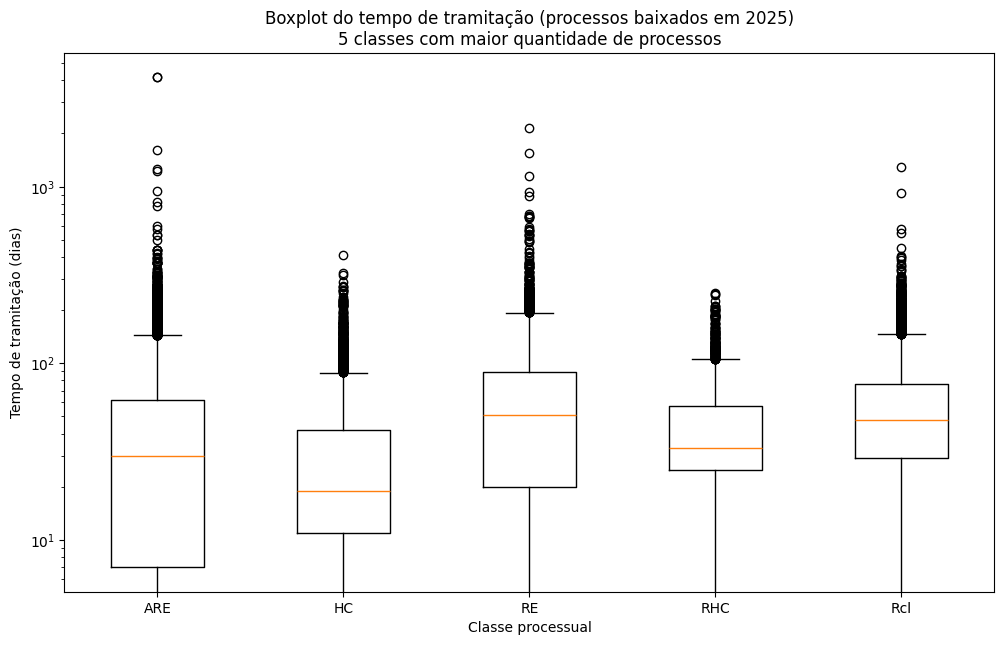

In [0]:

import matplotlib.pyplot as plt

# 1) Buscar dados (tempo_tramitacao) apenas das 5 classes mais frequentes, decididos em 2025
query = """
WITH top_classes AS (
    SELECT
        classe,
        COUNT(DISTINCT processo) AS qtde_processos
    FROM gold.vw_distribuicoes2025_decisoes
    WHERE tempo_tramitacao IS NOT NULL
      AND YEAR(data_baixa) = 2025
    GROUP BY classe
    ORDER BY qtde_processos DESC
    LIMIT 5
)
SELECT
    d.classe,
    d.tempo_tramitacao
FROM gold.vw_distribuicoes2025_decisoes d
JOIN top_classes t
  ON d.classe = t.classe
WHERE d.tempo_tramitacao IS NOT NULL
  AND YEAR(d.data_baixa) = 2025
"""

pdf = spark.sql(query).toPandas()

# 2) Ordenar as classes pelo volume (opcional, mas ajuda na leitura)
#    (se quiser, pode pegar a ordem do top_classes por outra query)
classes = sorted(pdf["classe"].unique())

# 3) Preparar os dados por classe
data_por_classe = [pdf.loc[pdf["classe"] == c, "tempo_tramitacao"].values for c in classes]

# 4) Plotar boxplot
plt.figure(figsize=(12, 7))
plt.boxplot(data_por_classe, labels=classes, showfliers=True)

plt.yscale("log")

plt.xlabel("Classe processual")
plt.ylabel("Tempo de tramitação (dias)")
plt.title("Boxplot do tempo de tramitação (processos baixados em 2025)\n5 classes com maior quantidade de processos")

plt.show()


**Tempo de análise para o Relator proferir decisão final**

Avaliando quanto tempo os Ministros do STF demoram para proferir uma 'Decisão Final', observa-se que a Presidência tem uma média mais baixa em relação aos demais Ministros (10 dias), o que faz sentido com as atribuições dela, para fazer uma espécie de triagem de processos com poucas chances de admissibilidade.

Além disso, a média de tempo de análise do Ministro Relator varia bastante entre 20 e 60 dias para proferimento de 'Decisão Final'. 

Visto que os Ministros mais antigos na Corte possuem, em geral, tempo médio de análise menor (< 40 dias), uma possível explicação pode ser a maior experiência na organização dos gabinetes e a existência de menor volume de processos com grau de complexidade maior, por terem sido julgados em anos anteriores. 

In [0]:
%sql
WITH base AS (
    SELECT DISTINCT
        processo,
        classe,
        relator_atual_primeira AS relator,
        tempo_tramitacao,
        tempo_analise_relator,
        tipo_decisao_primeira 
    FROM gold.vw_distribuicoes2025_decisoes
    WHERE tempo_analise_relator IS NOT NULL
    AND tipo_decisao_primeira = "Decisão Final"
   
),
top_classes AS (
    SELECT
        classe
    FROM base
    GROUP BY classe
    ORDER BY COUNT(*) DESC
    LIMIT 5
)
SELECT
    b.relator,
    ROUND(AVG(b.tempo_analise_relator), 0) AS media_dias_ate_decisao,
    COUNT(*)                          AS qtde_processos
FROM base b
JOIN top_classes t
  ON b.classe = t.classe
GROUP BY b.relator
ORDER BY media_dias_ate_decisao, qtde_processos DESC;


relator,media_dias_ate_decisao,qtde_processos
MINISTRO PRESIDENTE,10.0,33138
MIN. DIAS TOFFOLI,22.0,3942
VICE-PRESIDENTE,27.0,297
MIN. CÁRMEN LÚCIA,33.0,4055
MIN. ALEXANDRE DE MORAES,33.0,3902
MIN. EDSON FACHIN,33.0,2527
MIN. GILMAR MENDES,36.0,3714
MIN. CRISTIANO ZANIN,45.0,4026
MIN. FLÁVIO DINO,45.0,3849
MIN. LUIZ FUX,51.0,3691


**Tempo de tramitação para julgamento do recurso interno interposto**

Outra medida de interesse é o tempo para análise de um recurso interno interposto no STF (Embargos de Declaração, Agravo Regimental, Embargos de Divergência, etc.). Avaliando os processos decididos em 2025, observa-se que essa decisão de recursos internos demora por volta de 50 dias na grande maioria dos casos.

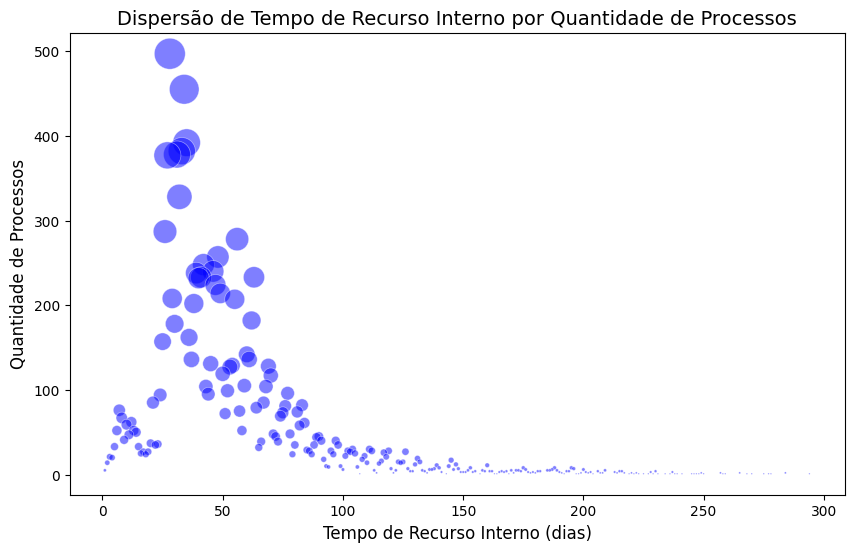

In [0]:
import matplotlib.pyplot as plt

# Consulta SQL no Databricks
query = """
SELECT
    tempo_recurso_interno,
    COUNT(DISTINCT processo) AS qtde_processos
FROM gold.vw_distribuicoes2025_decisoes
WHERE tempo_recurso_interno IS NOT NULL
GROUP BY tempo_recurso_interno
ORDER BY qtde_processos DESC
"""

# Carregar os dados em um DataFrame do Spark
df = spark.sql(query)

# Converter para Pandas para facilitar o gráfico
df_pandas = df.toPandas()

# Dados para o gráfico
x = df_pandas['tempo_recurso_interno']  # Eixo X: Tempo do recurso interno
y = df_pandas['qtde_processos']  # Eixo Y: Quantidade de processos
size = y  # Tamanho das bolhas (quantidade de processos)

# Criando o gráfico de bolhas
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=size, alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Títulos e rótulos
plt.title('Dispersão de Tempo de Recurso Interno por Quantidade de Processos', fontsize=14)
plt.xlabel('Tempo de Recurso Interno (dias)', fontsize=12)
plt.ylabel('Quantidade de Processos', fontsize=12)

# Exibir o gráfico
plt.show()

#### 5.3 Identificando as principais variáveis para julgados favoráveis e desfavoráveis

**Total de processos classificados pelo desfecho**

Analisando a classificação feita da conclusão dos julgamentos realizados pelos Ministros e Órgãos do STF, percebe-se que, aproximadamente, 70% dos processos não tem suas pretensões acolhidas, além de que 19% dos processos foram remetidos indevidamente ao STF, considerando a sistemática de julgamento de Repercussão Geral.

Esse não é um dado que impressiona quem atua com Tribunais Superiores, mas que evidencia que a maior parte do trabalho realizado pela Suprema Corte não altera a situação das partes que a ele recorrem, demonstrando uma ineficiência do sistema judicial.



In [0]:
%sql

WITH base AS (
    SELECT
        resultado_final_classificado,
        COUNT(DISTINCT processo) AS qtde_processos
    FROM gold.vw_resultado_decisao_final_2025
    GROUP BY resultado_final_classificado
)
SELECT
    resultado_final_classificado,
    qtde_processos,
    ROUND(
        100.0 * qtde_processos / SUM(qtde_processos) OVER (),
        2
    ) AS percentual_total_desfecho
FROM base
ORDER BY qtde_processos DESC;



resultado_final_classificado,qtde_processos,percentual_total_desfecho
desfavoravel,51083,69.64
devolucao,14002,19.09
favoravel,6891,9.39
sigiloso,772,1.05
homologacao,606,0.83


**Processos classificados pelo desfecho e por órgão julgador do STF**

A presente consulta mantém a congruência com os índices de não provimento, destacando-se que as decisões proferidas nos órgãos colegiados raramento são favoráveis aos seus autores. É relevante destacar que os órgãos colegiados, geralmente, decidem casos de recurso interno, o que significa que na imensa maioria das vezes (> 90%) as decisões monocráticas são mantidas.



In [0]:
%sql
WITH base AS (
    SELECT
        orgao_julgador,
        resultado_final_classificado,
        COUNT(DISTINCT processo) AS qtde
    FROM gold.vw_resultado_decisao_final_2025
    GROUP BY orgao_julgador, resultado_final_classificado
)
SELECT
    orgao_julgador,
    resultado_final_classificado,
    qtde,
    ROUND(
        100.0 * qtde / SUM(qtde) OVER (PARTITION BY orgao_julgador),
        2
    ) AS percentual_no_orgao
FROM base
ORDER BY orgao_julgador, qtde DESC;




orgao_julgador,resultado_final_classificado,qtde,percentual_no_orgao
1ª TURMA,desfavoravel,4276,97.31
1ª TURMA,favoravel,118,2.69
2ª TURMA,desfavoravel,3800,95.07
2ª TURMA,favoravel,196,4.90
2ª TURMA,devolucao,1,0.03
MONOCRÁTICA,desfavoravel,40166,64.74
MONOCRÁTICA,devolucao,13997,22.56
MONOCRÁTICA,favoravel,6500,10.48
MONOCRÁTICA,sigiloso,772,1.24
MONOCRÁTICA,homologacao,606,0.98


**Processos classificados pelo desfecho e por Tribunal de origem**

Analisando o desfecho dos processo no STF pelo Tribunal de origem, observamos que, em geral, a situação não distoa da análise geral, verificando-se baixos índices de julgamentos favoráveis ao autor da ação/recurso.

Situação que chama a atenção é dos processos com origem no STF (denominados de processos originários, dentre os quais as Reclamações que são uma das 5 classes mais volumosas de processos no Supremo) e os provenientes dos TRF's da 1ª e da 4ª Região.

No caso dos processos originários do STF, observamos um alto percentual de julgamentos desfavoráveis (> 70%) em linha com a média geral, mas um percentual também muito elevado para julgamentos **favoráveis** (22%), que representa mais que o dobro da média geral de decisões favoráveis (9%).

Já os TRF's da 1ª e da 4ª Região o que chama a atenção é o percentual de julgamentos **desfavoráveis** que são bem inferiores à média geral, mesmo o percentual de decisões favoráveis se mantendo em níveis muito baixos. Essa situação decorre, provavelmente, de um grande volume de decisões com resulta final de outra categoria (sobrestamento, sigiloso, etc.). 



In [0]:
%sql

WITH base AS (
    SELECT
        tribunal_origem,
        resultado_final_classificado,
        COUNT(DISTINCT processo) AS qtde_processos
    FROM gold.vw_resultado_decisao_final_2025
    GROUP BY tribunal_origem, resultado_final_classificado
),
calc AS (
    SELECT
        tribunal_origem,
        resultado_final_classificado,
        qtde_processos,
        SUM(qtde_processos) OVER (PARTITION BY tribunal_origem) AS total_tribunal,
        ROUND(
            100.0 * qtde_processos / SUM(qtde_processos) OVER (PARTITION BY tribunal_origem),
            2
        ) AS percentual_no_tribunal
    FROM base
)
SELECT *
FROM calc
WHERE resultado_final_classificado IN ('desfavoravel', 'favoravel')
  AND total_tribunal > 800
ORDER BY resultado_final_classificado, qtde_processos DESC;






tribunal_origem,resultado_final_classificado,qtde_processos,total_tribunal,percentual_no_tribunal
SUPREMO TRIBUNAL FEDERAL,desfavoravel,20795,28070,74.08
TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,desfavoravel,6178,7997,77.25
TRIBUNAL REGIONAL FEDERAL DA 4ª REGIÃO,desfavoravel,1869,3393,55.08
TRIBUNAL DE JUSTIÇA DO ESTADO DE MINAS GERAIS,desfavoravel,1569,2055,76.35
TRIBUNAL DE JUSTIÇA DO ESTADO DE SANTA CATARINA,desfavoravel,1392,1631,85.35
SUPERIOR TRIBUNAL DE JUSTIÇA,desfavoravel,1385,1555,89.07
TRIBUNAL REGIONAL FEDERAL DA 3ª REGIÃO,desfavoravel,1379,1957,70.46
TRIBUNAL DE JUSTIÇA DO ESTADO DO RIO GRANDE DO SUL,desfavoravel,1331,1740,76.49
TRIBUNAL DE JUSTIÇA DO ESTADO DO RIO DE JANEIRO,desfavoravel,1282,1689,75.90
TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E TERRITÓRIOS,desfavoravel,981,1366,71.82


Visualizando as decisões favoráveis proferidas em processos com origem no STF, observa-se que a quase totalidade foi em processos de Reclamação e *Habeas Corpus*, sendo que os temas mais recorrentes são Direito do Trabalho e Direito Penal.

Esse volume pode ser explicado pelo julgamento do Tema nº 1.118 da Repercussão Geral do STF, que definiu questão sobre responsabilidade de entes públicos pelo pagamento de verbas trabalhistas decorrentes de contratos de terceirização de mão de obra e possuía grande quantidade de processos sobre a matéria.

Enquanto que os assuntos em relação ao Direito Processual Penal estão mais diluídos em diversos temas diferentes. 

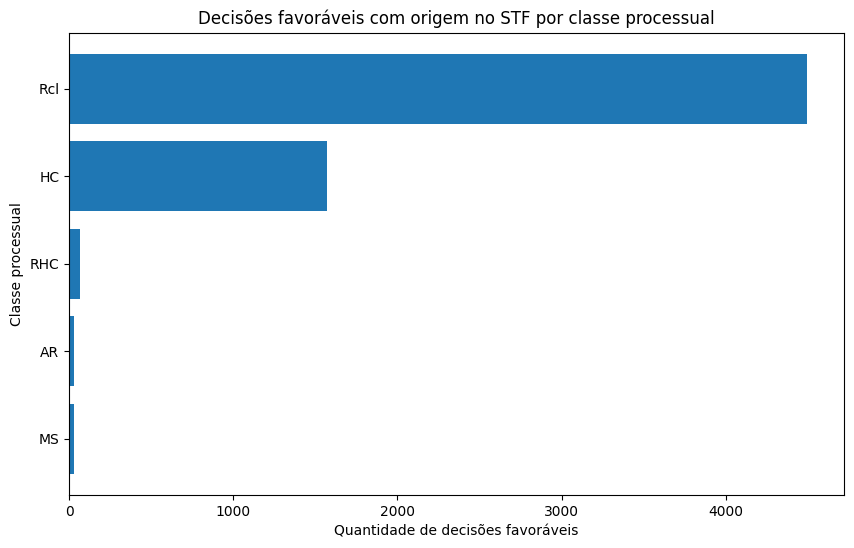

In [0]:

query = """
WITH base AS (
    SELECT
        classe,
        COUNT(DISTINCT processo) AS qtde_decisoes
    FROM gold.vw_resultado_decisao_final_2025
    WHERE upper(trim(tribunal_origem)) = 'SUPREMO TRIBUNAL FEDERAL'
      AND lower(trim(resultado_final_classificado)) = 'favoravel'
    GROUP BY classe
)
SELECT *
FROM base
ORDER BY qtde_decisoes DESC
LIMIT 5
"""


df = spark.sql(query).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(df["classe"], df["qtde_decisoes"])

plt.xlabel("Quantidade de decisões favoráveis")
plt.ylabel("Classe processual")
plt.title(    
    "Decisões favoráveis com origem no STF por classe processual"
)

plt.gca().invert_yaxis()

plt.show()



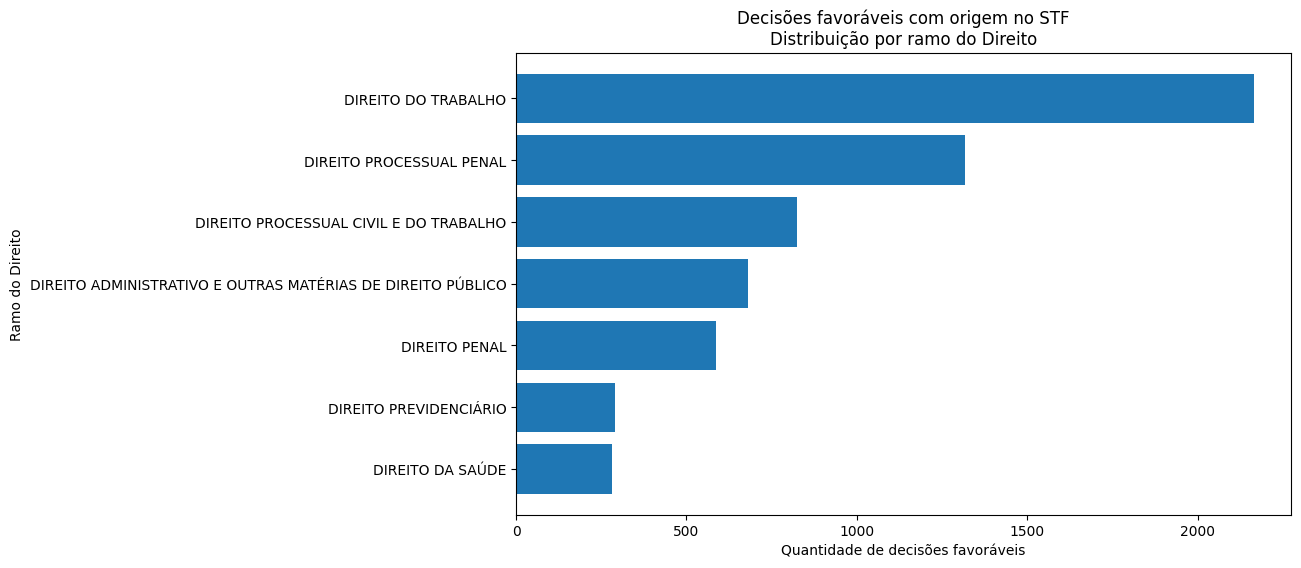

In [0]:

query = """
WITH base AS (
    SELECT
        ramo_direito,
        COUNT(DISTINCT processo) AS qtde_decisoes
    FROM gold.vw_resultado_decisao_final_2025
    WHERE upper(trim(tribunal_origem)) = 'SUPREMO TRIBUNAL FEDERAL'
      AND lower(trim(resultado_final_classificado)) = 'favoravel'
    GROUP BY ramo_direito
)
SELECT *
FROM base
WHERE qtde_decisoes > 250
ORDER BY qtde_decisoes DESC
"""

df = spark.sql(query).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(df["ramo_direito"], df["qtde_decisoes"])

plt.xlabel("Quantidade de decisões favoráveis")
plt.ylabel("Ramo do Direito")
plt.title(
    "Decisões favoráveis com origem no STF\n"
    "Distribuição por ramo do Direito"
)

plt.gca().invert_yaxis()

plt.show()


In [0]:
%sql

SELECT
    assuntos_processo,
    COUNT(DISTINCT processo) AS qtde_decisoes
FROM gold.vw_resultado_decisao_final_2025
WHERE upper(trim(ramo_direito)) = 'DIREITO DO TRABALHO'
AND lower(trim(resultado_final_classificado)) = 'favoravel'
GROUP BY assuntos_processo
ORDER BY qtde_decisoes DESC
LIMIT 5;

assuntos_processo,qtde_decisoes
DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | RESPONSABILIDADE SOLIDÁRIA/SUBSIDIÁRIA | TERCEIRIZAÇÃO/TOMADOR DE SERVIÇOS | ENTE PÚBLICO,922
DIREITO DO TRABALHO | CONTRATO INDIVIDUAL DE TRABALHO | RECONHECIMENTO DE RELAÇÃO DE EMPREGO,369
DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | CONTRATO INDIVIDUAL DE TRABALHO | RECONHECIMENTO DE RELAÇÃO DE EMPREGO,339
DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | RESPONSABILIDADE SOLIDÁRIA/SUBSIDIÁRIA | TERCEIRIZAÇÃO/TOMADOR DE SERVIÇOS | LICITUDE/ILICITUDE,71
"DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | VERBAS REMUNERATÓRIAS, INDENIZATÓRIAS E BENEFÍCIOS",70
"DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | VERBAS REMUNERATÓRIAS, INDENIZATÓRIAS E BENEFÍCIOS | SALÁRIO/DIFERENÇA SALARIAL",63
DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | RESPONSABILIDADE SOLIDÁRIA/SUBSIDIÁRIA,37
DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | CONTRATO INDIVIDUAL DE TRABALHO | ADMINISTRAÇÃO PÚBLICA | CONVERSÃO DE REGIME JURÍDICO,27
DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | RESPONSABILIDADE SOLIDÁRIA/SUBSIDIÁRIA | TERCEIRIZAÇÃO/TOMADOR DE SERVIÇOS,25
DIREITO DO TRABALHO | DIREITO INDIVIDUAL DO TRABALHO | RESPONSABILIDADE SOLIDÁRIA/SUBSIDIÁRIA | GRUPO ECONÔMICO,24


In [0]:
%sql

SELECT
    assuntos_processo,
    COUNT(DISTINCT processo) AS qtde_decisoes
FROM gold.vw_resultado_decisao_final_2025
WHERE upper(trim(ramo_direito)) = 'DIREITO PROCESSUAL PENAL'
AND lower(trim(resultado_final_classificado)) = 'favoravel'
GROUP BY assuntos_processo
ORDER BY qtde_decisoes DESC
LIMIT 10;

assuntos_processo,qtde_decisoes
DIREITO PROCESSUAL PENAL | PRISÃO PREVENTIVA | REVOGAÇÃO,266
DIREITO PROCESSUAL PENAL | AÇÃO PENAL | NULIDADE,142
DIREITO PROCESSUAL PENAL | LIBERDADE PROVISÓRIA,132
DIREITO PROCESSUAL PENAL | EXECUÇÃO PENAL E DE MEDIDAS ALTERNATIVAS | PENA PRIVATIVA DE LIBERDADE | PROGRESSÃO DE REGIME,126
DIREITO PROCESSUAL PENAL | AÇÃO PENAL | SUSPENSÃO,115
DIREITO PROCESSUAL PENAL | AÇÃO PENAL | NULIDADE | CERCEAMENTO DE DEFESA,79
DIREITO PROCESSUAL PENAL | AÇÃO PENAL | PROVAS | PROVA ILÍCITA,75
DIREITO PROCESSUAL PENAL | PRISÃO DOMICILIAR / ESPECIAL,48
DIREITO PROCESSUAL PENAL | AÇÃO PENAL,47
DIREITO PROCESSUAL PENAL | AÇÃO PENAL | TRANCAMENTO,37


**Processos classificados pelo desfecho e por ramo do Direito**

Avaliando agora a tendência de resultado dos julgamentos pelo ramo do direito, observamos alguns pontos destacados acima para os processos originários no STF, que tiveram um maior índice de provimento para o Direito do Trabalho, chamando a atenção as decisões de Direito Ambiental, cujos desfechos foram todos desfavoráveis aos autores.

Dois pontos merecem uma análise mais detida, que são: a) a quantidade de decisões favoráveis no Direito à saúde; e b) a quantidade de decisões de devolução de processos de Direito à educação


In [0]:
%sql

WITH base AS (
  SELECT
    ramo_direito,
    resultado_final_classificado,
    COUNT(DISTINCT processo) AS qtde
FROM gold.vw_resultado_decisao_final_2025
GROUP BY ramo_direito, resultado_final_classificado
)
SELECT
    ramo_direito,
    resultado_final_classificado,
    qtde,
    SUM(qtde) OVER (PARTITION BY ramo_direito) AS total_ramo,
    ROUND(
        100.0 * qtde / SUM(qtde) OVER (PARTITION BY ramo_direito),
        2
    ) AS percentual_no_tribunal
FROM base
WHERE qtde > 200
ORDER BY resultado_final_classificado, percentual_no_tribunal DESC;


ramo_direito,resultado_final_classificado,qtde,total_ramo,percentual_no_tribunal
DIREITO AMBIENTAL,desfavoravel,222,222,100.00
DIREITO PENAL,desfavoravel,6666,7577,87.98
DIREITO PROCESSUAL PENAL,desfavoravel,15166,18106,83.76
DIREITO CIVIL,desfavoravel,2723,3622,75.18
DIREITO TRIBUTÁRIO,desfavoravel,5153,7512,68.60
DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO,desfavoravel,10961,17373,63.09
DIREITO DA SAÚDE,desfavoravel,1012,1636,61.86
DIREITO PROCESSUAL CIVIL E DO TRABALHO,desfavoravel,3616,5893,61.36
DIREITO PREVIDENCIÁRIO,desfavoravel,1912,3302,57.90
DIREITO DO CONSUMIDOR,desfavoravel,583,1022,57.05



No que toca ao volume expressivo de decisões favoráveis em Direito da saúde, infere-se do gráfico a seguir que os assuntos mais recorrentes são sobre fornecimento de medicamentos, o que se explica por outro Tema de Repercussão Geral o de nº 1.234, que tratava sobre requisitos para decisões judicias imporem ao Poder Público o fornecimento de medicamentos demandados pelo cidadão. 

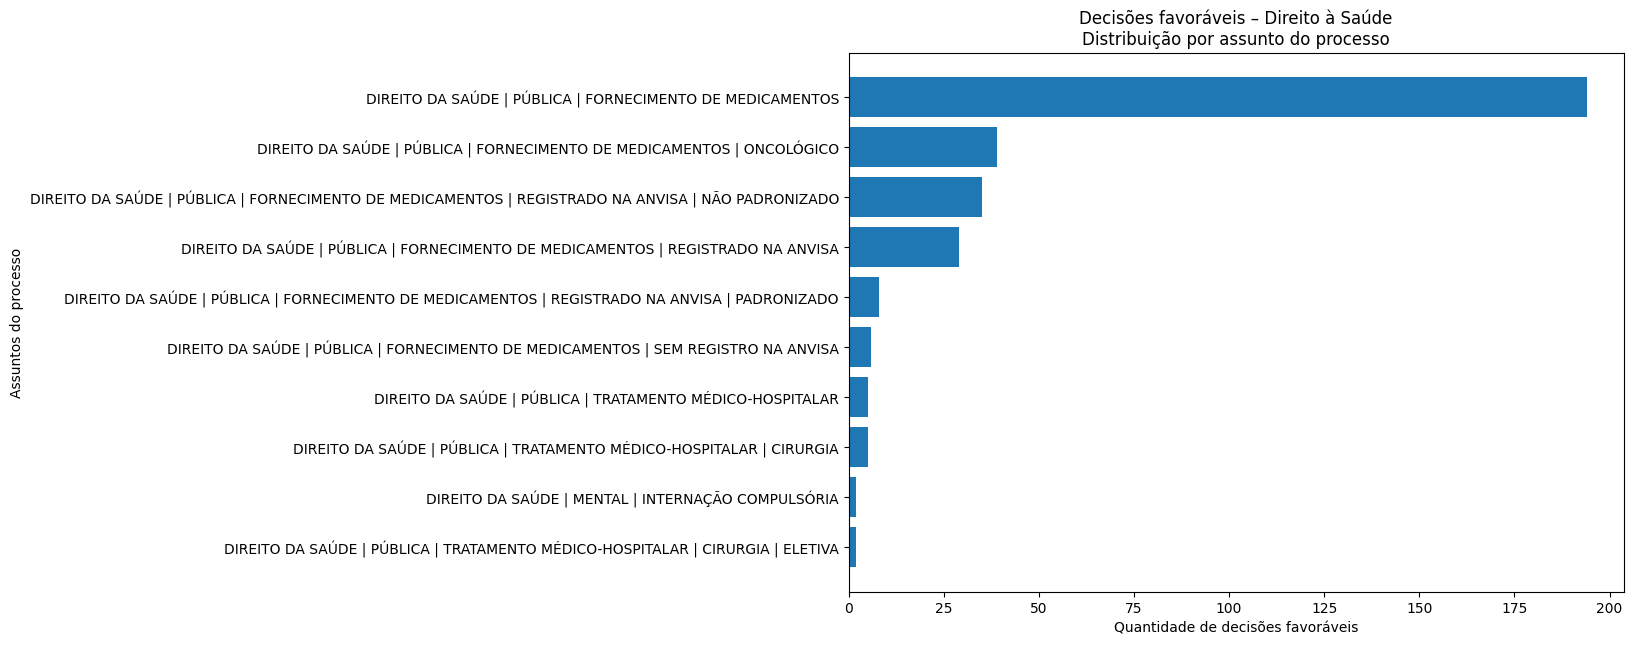

In [0]:

query = """
SELECT
    assuntos_processo,
    COUNT(DISTINCT processo) AS qtde_decisoes
FROM gold.vw_resultado_decisao_final_2025
WHERE upper(trim(ramo_direito)) = 'DIREITO DA SAÚDE'
  AND lower(trim(resultado_final_classificado)) = 'favoravel'
GROUP BY assuntos_processo
ORDER BY qtde_decisoes DESC
LIMIT 10
"""

df = spark.sql(query).toPandas()

plt.figure(figsize=(10, 7))
plt.barh(df["assuntos_processo"], df["qtde_decisoes"])

plt.xlabel("Quantidade de decisões favoráveis")
plt.ylabel("Assuntos do processo")
plt.title(
    "Decisões favoráveis – Direito à Saúde\n"
    "Distribuição por assunto do processo"
)

plt.gca().invert_yaxis()

plt.show()



Quanto ao grande número de decisões de devolução de processos relacionados ao Direito à educação, verificamos que 269 das 388 decisões possuem um mesmo assunto, que está relacionado, provavelmente, ao Tema nº 1.218 da Repercussão Geral do STF, que busca resolver a questão de reflexos do piso nacional do magistério sobre os planos de carreiras do professores servidores públicos.

In [0]:
%sql

SELECT
    assuntos_processo,
    COUNT(DISTINCT processo) AS qtde_decisoes
FROM gold.vw_resultado_decisao_final_2025
WHERE upper(trim(ramo_direito)) = 'DIREITO À EDUCAÇÃO'
AND lower(trim(resultado_final_classificado)) = 'devolucao'
GROUP BY assuntos_processo
ORDER BY qtde_decisoes DESC
LIMIT 5;



assuntos_processo,qtde_decisoes
DIREITO À EDUCAÇÃO | VALORIZAÇÃO DO MAGISTÉRIO E DOS PROFISSIONAIS DA EDUCAÇÃO | REMUNERAÇÃO | PISO SALARIAL,269
DIREITO À EDUCAÇÃO | FINANCIAMENTO | FINANCIAMENTO PRIVADO DO ENSINO SUPERIOR E/OU PESQUISA,30
DIREITO À EDUCAÇÃO | PERMANÊNCIA | PROGRAMAS DE BOLSAS E FINANCIAMENTO ESTUDANTIL COM RECURSOS PÚBLICOS | FIES,28
DIREITO À EDUCAÇÃO | FINANCIAMENTO | DESPESA | MANUTENÇÃO E DESENVOLVIMENTO DO ENSINO,11
"DIREITO À EDUCAÇÃO | EDUCAÇÃO SUPERIOR | GRADUAÇÃO (BACHARELADO, LICENCIATURA, PROFISSIONAL TECNOLÓGICA)",9


### 5.3 Resposta das perguntas iniciais




1. Quais e quantos processos foram autuados no ano de 2025?

**Pela consulta feita, foi identificada a distribuição/registro de 77.557 processos distintos no STF para o ano de 2025.** 
**A grande maioria dos processos autuados em 2025 no STF são da classe processual de Agravo em Recurso Extraordinário (ARE), seguidos de Rclamação (Rcl) e *Habeas Corpus* (HC).**

2. É possível identificar as pessoas e entidades com maior quantidade de recursos e o polo processual que elas ocupam?

**Como discutido na análise de qualidade dos dados, em decorrência da grande quantidade de nulos nos campos de partes dos processo (polo_ativo e polo_passivo), não foi possível responder a essa pergunta por ausência de dados, bem como não foram encontrados dados complementares em outras fontes.**
**Assim, a resposta da questão ficou prejudicada por ausência de dados.**

3. Qual o resultado dos julgamentos desses processos?

**Pelos dados consultados, é possível inferir que foram proferidas 86.724 decisões nos 77.557 processos autuados em 2025, sendo que mais de 82% dessas decisões foram do tipo "Decisão Final", que julgam o processo.**
**Além disso, foram proferidas 11.682 decisões em recursos interno, o que representa uma taxa de recorribilidade interna de, aproximadamente, 16% das decisões monocráticas proferidas pelos Ministros do Supremo.**

4. Existe alguma tendência nos julgamentos (favoráveis ou desfavoráveis) por tema, origem ou pessoa/entidade?

**Pelos dados analisados, observou-se que o julgamento desfaverável ao autor da ação/recurso é a regra, mas há uma tendência a um maior índice de decisão favorável em processos originários do STF das classes de Reclamação e _Habeas Corpus_, bem como o julgamento de alguns temas específicos na sistemática de Repercussão Geral influenciam no desfecho do processo.**
**Quanto à tendência de julgamento por pessoa/entidade, essa questão ficou prejudicada pelos motivos expostos na resposta da pergunta 2.**


5. Qual tempo médio de tramitação dos processos em geral e por Ministro Relator?

**Dos processos decididos em 2025, o tempo médio de tramitação foi de 48 dias, desde a data de autuação até a data da baixa do processo.**
**Das 5 classes processuais mais recorrentes, os Agravos em RE, os HC's e os Recursos em HC são decididos, em média, entre 30 e 45 dias, sendo que os RE's e as Reclamações demoram um pouco mais, em torno de 60 dias.**
**Avaliando quanto tempo os Ministros do STF demoram para proferir uma 'Decisão Final', observa-se que a Presidência tem uma média mais baixa em relação aos demais Ministros (10 dias), o que faz sentido com as atribuições dela, para fazer uma espécie de triagem de processos com poucas chances de admissibilidade.**
**Além disso, a média de tempo de análise do Ministro Relator varia bastante entre 20 e 60 dias para proferimento de 'Decisão Final'.** 



#### 6. Auto avaliação 

No início do projeto eu tive bastante dificuldade com coisas simples, tais como requisição de dados de API e a ingestão dos dados de forma manual ou automatizada no _cluster_. Após algumas semanas pesquisando na internet e com auxílio de IA assistente, consegui resolver boa parte dos problemas iniciais.

Eu venho de uma formação em outra área, sou formado em Direito, e acredito que isso tenha influenciado bastante nessa dificuldade inicial.

Percebi, ainda, que parte das dificuldades decorreram de interfaces de dados abertos com certa complexidade pelos Tribunais Superiores, por exemplo, o STF disponibiliza dados em arquivos para download, mas não fornece o _link_ para requisições diretas, sendo necessário a construção de robô para baixar os dados no site do projeto Corte Aberta.

Por sua vez, o STJ fornece seus dados por meio de API, sendo que estes são disponibilizados em arquivos JSON de periodicidade diária, o que também gera uma maior complexidade na ingestão desses dados e sua compilação, o que me levou a desistir da utilização desses dados para o projeto.

Ultrapassados os problemas iniciais, entendo que consegui desenvolver bem algumas outras competências aprendidas na _sprint_ de engenharia de dados, podendo ter experiência prática das dificuldades que se enfrantam na construção de um banco de dados real, como a redundância e perda de informações com certas manipulações e a ausência de informações que supostamente seriam fornecidos.

Também consegui atingir os objetivos iniciais e construir um banco de dados que identifica a distribuição de processos no STF, com características como classe processual, origem, relator, tempo de tramitação no tribunal, além de conseguir especificar a conclusão do julgamento proferido e relacionar com cada um dos processos distribuídos. Isso possibilita que um gestor que trabalha com demandas judiciais massificadas tenha uma visão desde o início do processo no STF até seu encerramento, faça estimativas de chances de êxito de uma demanda, tempo de tramitação do recurso principal e de eventuais recursos internos, podendo calibrar e redefinir sua estratégia.

Tive êxito em responder as perguntas iniciais, exceto pelas perguntas 2 e parte da 4, em virtude da existência de muitos valores ausentes de nome das partes do processo, o que inviabilizou as análises quanto as entidades que compunham os processos.

Como melhoramentos que pretendo implementar no futuro no projeto iniciado, entendo que seria muito importante a normalização dos dados, especialmente, do conjunto de dados de decisões, que possuem muitas redundâncias, pensando em criar uma entidade para cada 'Tipo de Decisão', como forma de evitar perda de infomrações e possibilitar uma análise mais robusta desses dados.

Um incremento que também pretendo fazer é a integração dos dados fornecidos pelo STJ, para ampliar o escopo de análise, criando um banco de dados robusto, que poderá ser utilizado em minha atuação profissional de gestão processual junto aos Tribunais Superiores, implementando métricas e modelos preditivos para processos que ainda não foram julgados por essas Cortes.